In [1]:
# 📌 Cell 1: Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import umap
from keras.saving import register_keras_serializable

2025-03-25 14:10:10.787862: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 14:10:10.818030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742892010.857771   22101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742892010.878640   22101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 14:10:10.912801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 📌 Cell 2: Register Gradient Reversal Layer for loading
@register_keras_serializable()
class GradientReversal(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)  # allows name, dtype, etc.

    def call(self, x):
        @tf.custom_gradient
        def reverse_gradient(x):
            def grad(dy):
                return -dy
            return x, grad
        return reverse_gradient(x)

    def get_config(self):
        config = super().get_config()
        return config

In [3]:
# 📌 Cell 3: Load Best Fusion Model
model_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/simCLR_DANN_Fusion/best_fusion_model/best_simCLR_DANN_fusionModel.keras"
model = tf.keras.models.load_model(model_path, compile=False, custom_objects={"GradientReversal": GradientReversal})

I0000 00:00:1742892022.007625   22101 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
# 📌 Cell 4: Load Test Dataset
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CROPS = 9
NUM_DISEASES = 33

feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "crop": tf.io.FixedLenFeature([], tf.int64),
    "disease": tf.io.FixedLenFeature([], tf.int64)
}

def parse_example(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE]) / 255.0
    return image, (example['crop'], example['disease'])

test_dataset_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Dataset/PlantVillage_Structured/AUG_TFRecord/split/test.tfrecord"
test_dataset = tf.data.TFRecordDataset(test_dataset_path)
test_dataset = test_dataset.map(parse_example).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
# 📌 Cell 5: Predict on Test Set
y_true_crop, y_true_disease = [], []
y_pred_crop, y_pred_disease = [], []
features = []

for images, (crop_labels, disease_labels) in test_dataset:
    preds = model(images, training=False)
    y_true_crop.extend(crop_labels.numpy())
    y_true_disease.extend(disease_labels.numpy())
    y_pred_crop.extend(tf.argmax(preds[1], axis=1).numpy())  # domain head = crop
    y_pred_disease.extend(tf.argmax(preds[0], axis=1).numpy())  # disease head
    features.append(model.layers[1](images).numpy())  # encoder features

features = np.concatenate(features, axis=0)

2025-03-25 14:10:25.145542: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1742892025.621220   22101 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-25 14:11:30.492023: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# 📌 Cell 6: Classification Reports and Save
os.makedirs("reports/Fusion_Model", exist_ok=True)
report_crop = classification_report(y_true_crop, y_pred_crop, digits=4)
report_disease = classification_report(y_true_disease, y_pred_disease, digits=4)

with open("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/Fusion_Model/classification_reports.txt", "w") as f:
    f.write("Crop Classification Report:\n")
    f.write(report_crop + "\n")
    f.write("Disease Classification Report:\n")
    f.write(report_disease)


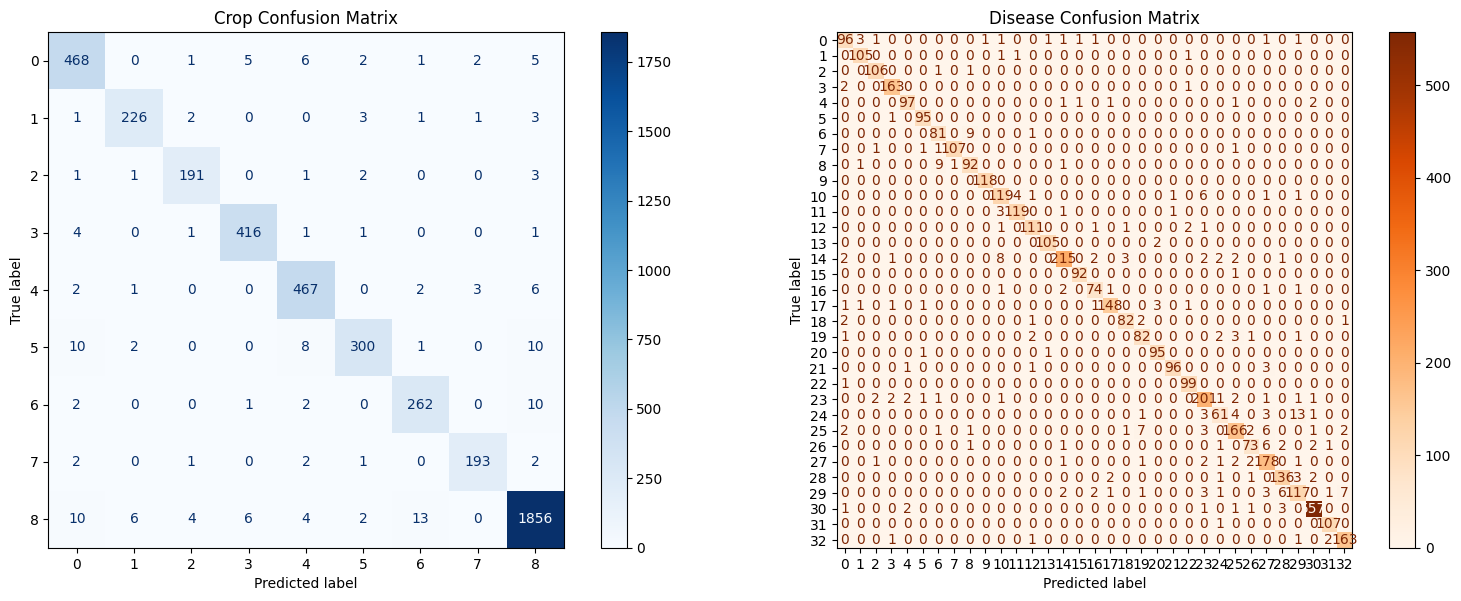

In [7]:
# 📌 Cell 7: Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ConfusionMatrixDisplay.from_predictions(y_true_crop, y_pred_crop, ax=ax[0], cmap="Blues")
ax[0].set_title("Crop Confusion Matrix")
ConfusionMatrixDisplay.from_predictions(y_true_disease, y_pred_disease, ax=ax[1], cmap="Oranges")
ax[1].set_title("Disease Confusion Matrix")
plt.tight_layout()
plt.savefig("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/Fusion_Model/confusion_matrices.png")
plt.show()

/home/srivatsa/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


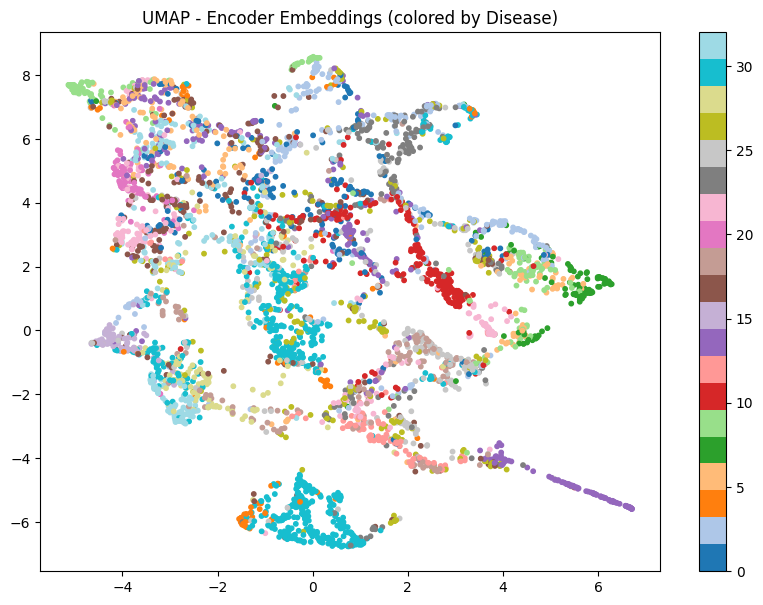

In [8]:
# 📌 Cell 8: UMAP Visualization
umap_proj = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(features)
plt.figure(figsize=(10, 7))
plt.scatter(umap_proj[:, 0], umap_proj[:, 1], c=y_true_disease, cmap='tab20', s=10)
plt.title("UMAP - Encoder Embeddings (colored by Disease)")
plt.colorbar()
plt.savefig("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/Fusion_Model/umap_disease_embeddings.png")
plt.show()

/home/srivatsa/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


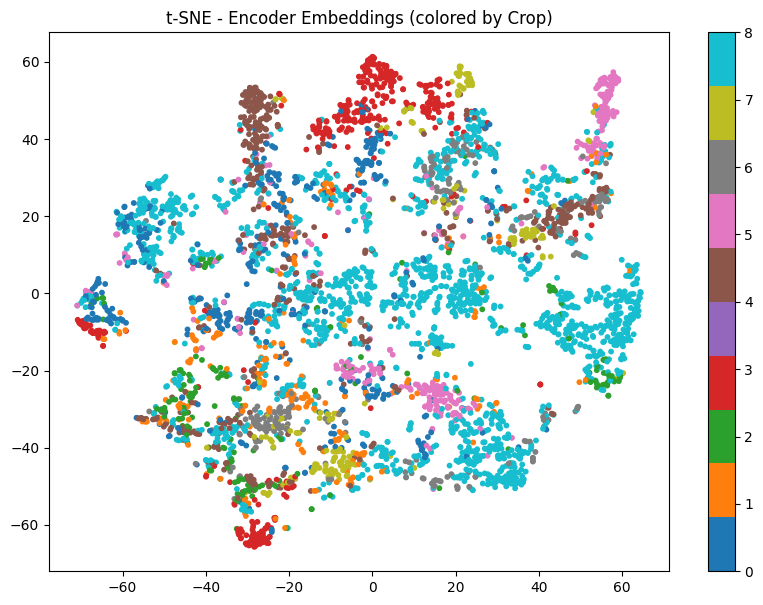

In [9]:
# 📌 Cell 9: t-SNE Visualization
tsne_proj = TSNE(n_components=2, perplexity=30, n_iter=1000).fit_transform(features)
plt.figure(figsize=(10, 7))
plt.scatter(tsne_proj[:, 0], tsne_proj[:, 1], c=y_true_crop, cmap='tab10', s=10)
plt.title("t-SNE - Encoder Embeddings (colored by Crop)")
plt.colorbar()
plt.savefig("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/Fusion_Model/tsne_crop_embeddings.png")
plt.show()

In [10]:
# 📌 Cell 10: Save Label Mappings
crop_map = {0: 'Grape', 1: 'Apple', 2: 'Bell_Pepper', 3: 'Corn', 4: 'Strawberry', 5: 'Tomato', 6: 'Cherry', 7: 'Peach', 8: 'Potato'}
disease_map = {i: f"Disease_{i}" for i in range(NUM_DISEASES)}

with open("/home/srivatsa/Multiple_Crop_Disease_Detection/reports/Fusion_Model/label_mappings.txt", "w") as f:
    f.write("Crop Labels:\n")
    for k, v in crop_map.items():
        f.write(f"{k}: {v}\n")
    f.write("\nDisease Labels:\n")
    for k, v in disease_map.items():
        f.write(f"{k}: {v}\n")

print("✅ Visualization Complete. All results saved to 'reports/Fusion_Model/'")

✅ Visualization Complete. All results saved to 'reports/Fusion_Model/'
